<a href="https://colab.research.google.com/github/enderjp/Proyecto-de-grado/blob/main/Deep_Learning/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Librerías

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
#import tensorflow_datasets as tfds
import pandas as pd
import pathlib
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
import cv2
import os
import sys
import zipfile
import matplotlib.pyplot as plt


In [ ]:
# Importar imagenes
!unzip "/content/drive/MyDrive/imagenes_resized_96x96.zip" -d "/content"

#!unzip "/content/drive/MyDrive/UTKFace.zip" -d "/content"



In [ ]:
#from shutil import rmtree
#rmtree("imagenes_resized_64x64")

In [3]:
# data
# extraer imagenes y los nombres de cada una
path="/content/imagenes_resized_96x96/"
images=[]
files_names=[]

i=0
for filename  in os.listdir(path):
     
     img = cv2.imread(os.path.join(path,filename))
     #img = cv2.resize(img,(96,96))
     files_names.append(filename)
     images.append(img)
     print("Leyendo imagen n:",i)
     i+=1





Se han truncado las últimas 5000 líneas del flujo de salida.
Leyendo imagen n: 18691
Leyendo imagen n: 18692
Leyendo imagen n: 18693
Leyendo imagen n: 18694
Leyendo imagen n: 18695
Leyendo imagen n: 18696
Leyendo imagen n: 18697
Leyendo imagen n: 18698
Leyendo imagen n: 18699
Leyendo imagen n: 18700
Leyendo imagen n: 18701
Leyendo imagen n: 18702
Leyendo imagen n: 18703
Leyendo imagen n: 18704
Leyendo imagen n: 18705
Leyendo imagen n: 18706
Leyendo imagen n: 18707
Leyendo imagen n: 18708
Leyendo imagen n: 18709
Leyendo imagen n: 18710
Leyendo imagen n: 18711
Leyendo imagen n: 18712
Leyendo imagen n: 18713
Leyendo imagen n: 18714
Leyendo imagen n: 18715
Leyendo imagen n: 18716
Leyendo imagen n: 18717
Leyendo imagen n: 18718
Leyendo imagen n: 18719
Leyendo imagen n: 18720
Leyendo imagen n: 18721
Leyendo imagen n: 18722
Leyendo imagen n: 18723
Leyendo imagen n: 18724
Leyendo imagen n: 18725
Leyendo imagen n: 18726
Leyendo imagen n: 18727
Leyendo imagen n: 18728
Leyendo imagen n: 18729
Ley

In [4]:
# construir DF con las etiquetas (presentes en files_names)

# DFs a utilizar
labels = pd.DataFrame(columns=('edad', 'genero', 'raza'))
edad, genero, raza= [], [], []
# cont=0
for cadena in files_names:
    
        if cadena[0]!='_' and cadena[1]!='_' and cadena[2]!='_':
            edad.append(int(cadena[0:3]))
            genero.append(int(cadena[4]))
            raza.append(int(cadena[6]))
            
        elif cadena[0]!='_' and cadena[1]!='_':
            edad.append(int(cadena[0:2]))
            genero.append(int(cadena[3]))
            raza.append(int(cadena[5]))
        else :
            edad.append(int(cadena[0]))
            genero.append(int(cadena[2]))
            raza.append(int(cadena[4]))
        

# construyo el DF con las etiquetas
labels['edad']=edad
labels['genero']=genero
labels['raza']=raza  

In [5]:
# La etiqueta edad se distribuye en clases en los rangos planteados

for i in range(len(labels)):
    if ((labels.loc[i,'edad'] >=0) & (labels.loc[i,'edad'] <=10)):
        labels.loc[i,'edad']=0
    elif ((labels.loc[i,'edad'] >=11) & (labels.loc[i,'edad'] <=20)):
        labels.loc[i,'edad']=1
    elif ((labels.loc[i,'edad'] >=21) & (labels.loc[i,'edad'] <=35)):
        labels.loc[i,'edad']=2
    elif ((labels.loc[i,'edad'] >=36) & (labels.loc[i,'edad'] <=50)):
        labels.loc[i,'edad']=3
    elif ((labels.loc[i,'edad'] >=51) & (labels.loc[i,'edad'] <=65)):
        labels.loc[i,'edad']=4
    else:
        labels.loc[i,'edad']=5


In [6]:
# Para verificar que la GPU este activa
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
# Union de las clases Latino/M. Oriente e Indio

print("Uniendo las clases 3 y 4...")
for i in range(len(labels)):
    if labels.loc[i,'raza']==4:
        labels.loc[i,'raza']=3
raza=labels['raza']        
print("Cantidad de muestras por clase:")        
print(raza.value_counts())   


Uniendo las clases 3 y 4...
Cantidad de muestras por clase:
0    10067
3     5663
1     4524
2     3437
Name: raza, dtype: int64


In [9]:
# Número de muestras por cada grupo de edades
labels['edad'].value_counts()

2    10230
3     3993
0     3203
4     2909
5     1697
1     1659
Name: edad, dtype: int64

In [10]:
# Separacion de datos de entrenamiento y validación
# 80% entrenamiento
# 20% validación

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2,random_state=200,shuffle=True)


In [ ]:
# y_test['raza'].value_counts()

In [11]:
# Las imágenes se transforman a numpy arrays 
X_train = np.array(X_train)
X_test = np.array(X_test)

In [12]:
#Transformar las clases de las 3 etiquetas a categoricas (one hot encoding)
#Genero
genero_train= y_train['genero'].values
#genero_train = keras.utils.to_categorical(genero_train, 2) # num de clases
#etnia
raza_train= y_train['raza'].values
#etnia_train = keras.utils.to_categorical(etnia_train, 4) # num de clases
#edad
# num_clase3 = 100 
edad_train= y_train['edad'].values
#edad_train = keras.utils.to_categorical(edad_train, 117)

# Ahora para el set de validacion

genero_test= y_test['genero'].values
#genero_test = keras.utils.to_categorical(genero_test, 2) # num de clases
#etnia
raza_test= y_test['raza'].values
#etnia_test = keras.utils.to_categorical(etnia_test, 4) # num de clases
#edad
# num_clase3 = 100 
edad_test= y_test['edad'].values
#edad_test = keras.utils.to_categorical(edad_test, 117)



In [13]:
#  Importar el modelo preentrenado (transfer learning)
base_model =Xception(weights='imagenet', input_shape=(96, 96, 3 ), include_top=False)



83697664/83683744 [==============================] - 1s 0us/step


In [14]:

# Se congelan las capas de convolución de la red Xception
for layer in base_model.layers:
    layer.trainable = False




In [15]:
# Instalar keras tuner para la optimización de hiperparámetros
!pip install -U keras-tuner

     |████████████████████████████████| 97 kB 3.7 MB/s 


In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
# Construir la red neuronal convolucional
def build_model(hp):

  preprocess_input =tf.keras.applications.xception.preprocess_input
  inputs = tf.keras.Input(shape=(96, 96, 3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  # let's add 3 fully-connected layer and 3 outputs
  x1 = Dense(128, activation='relu')(x)
  x1 = BatchNormalization()(x1)
  x1 = Dropout(0.5)(x1)
  #x1 =Dropout(0.2)(x1)
  x1 = Dense(128, activation='relu')(x1)
  x1 = Dropout(0.5)(x1)
#x1 = BatchNormalization()(x1)
  x1 = Dense(64, activation='relu')(x1)
  x1 = Dropout(0.5)(x1)
  #x1 = Dense(256, activation='relu')(x1)
  # = BatchNormalization()(x1)
  #x1 = Dense(132, activation='relu')(x1)
  #x1 =Dropout(0.2)(x1)
  genero= Dense(2, activation='softmax',name='genero')(x1)

#------------------------------------------
# Raza
  x2= Dense(128, activation='relu')(x)
  x2 = BatchNormalization()(x2)
  x2 = Dropout(0.5)(x2)
#= BatchNormalization()(x2)
#x2 =Dropout(0.5)(x2)
  x2 = Dense(128, activation='relu')(x2)
#x2 = BatchNormalization()(x2)
  x2 = Dropout(0.5)(x2)
  x2= Dense(64, activation='relu')(x2)
  x2 = Dropout(0.5)(x2)
#x2 = BatchNormalization()(x2)
  x2 = Dense(64, activation='relu')(x2)
  x2 = Dropout(0.5)(x2)
  #x2 = Dense(132, activation='relu')(x2)
  raza= Dense(4, activation='softmax',name='raza')(x2)

#----------------------------
# Edad

  x3 = Dense(256, activation='relu')(x)
  x3 = BatchNormalization()(x3)
  x3 =Dropout(0.5)(x3)
  x3= Dense(256, activation='relu')(x3)
  #= BatchNormalization()(x3)
  x3=Dropout(0.5)(x3)

  x3 = Dense(64, activation='relu')(x3)
#x3 = BatchNormalization()(x3)
  x3= Dropout(0.5)(x3)
  x3 = Dense(164, activation='relu')(x3)
# #x3 = BatchNormalization()(x3)
# x3= Dropout(0.5)(x3)
# x3 = Dense(64, activation='relu')(x3)
# x3= Dropout(0.5)(x3)
# x3 = Dense(64, activation='relu')(x3)
  x3= Dropout(0.5)(x3)

  

  edad= Dense(6,activation='softmax',name='edad')(x3)

#  Este es el modelo que se entrenará
  model = Model(inputs=inputs, outputs=[genero,raza,edad])



# compile the model (should be done *after* setting layers to non-trainable)

# Esto se hizo para 3 optimizadoes: SGD, Adam y Adadelta

  model.compile(
    optimizer= keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate',  values=[1e-2, 1e-3, 1e-4])),
   # optimizer= keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate',  values=[1e-2, 1e-3, 1e-4])),
    #optimizer= keras.optimizer.Adadelta(learning_rate=hp.Choice('learning_rate',  values=[1e-2, 1e-3, 1e-4])),
  
    loss={
        "genero":  'sparse_categorical_crossentropy',
        "raza": 'sparse_categorical_crossentropy',
        "edad": 'sparse_categorical_crossentropy',
    },
    metrics={
        #"genero": [keras.metrics.CategoricalAccuracy()], 
        "genero": 'accuracy',
        "raza": 'accuracy', 
        "edad": 'accuracy',
           },
    #loss_weights={"genero": 1, "raza": 1,"edad": 0.005},
     loss_weights={"genero": 0.5, "raza": 1,"edad": 2},
    )
  return model

In [ ]:
# Definir el optimizador de parámetros

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=1,
    directory='content/drive/MyDrive',
    project_name='CNN_final3')

In [ ]:
#Mostrar esquema de entrenamiento
tuner.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# Realizar la optimización
# Esto genera un archivo .json con los resultados
tuner.search(X_train, [genero_train,raza_train,edad_train],
             epochs=15,
             validation_split=0.2,verbose=1,batch_size=32)

Trial 3 Complete [00h 04m 22s]
val_loss: 3.826566696166992

Best val_loss So Far: 3.3454482555389404
Total elapsed time: 00h 12m 52s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Guardar resultados en un csv a partir del json
import pandas as pd
df = pd.read_json (r'/content/content/drive/MyDrive/CNN3/trial_8ec5865c69412a1154bb0b32e66796c4/trial.json')
df.to_csv (r'tunning_sgd.csv', index = None)

In [ ]:

# Mejor modelo

best_model = tuner.get_best_models(num_models=1)

# ver resultados
tuner.results_summary()

In [ ]:
#Con los mejores parámetros realizar el entrenamiento de transfer learning
best_model

In [ ]:
#for layer in base_model.layers:
#    layer.trainable = False




In [17]:
# Mejor modelo - redefinicion


preprocess_input =tf.keras.applications.xception.preprocess_input
inputs = tf.keras.Input(shape=(96, 96, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x) # ### 0.3
# let's add 3 fully-connected layer and 3 outputs

# Genero
x1 = Dense(128, activation='relu')(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
#x1 =Dropout(0.2)(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
#x1 = BatchNormalization()(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
  #x1 = Dense(256, activation='relu')(x1)
  # = BatchNormalization()(x1)
  #x1 = Dense(132, activation='relu')(x1)
  #x1 =Dropout(0.2)(x1)
genero= Dense(2, activation='softmax',name='genero')(x1)

#------------------------------------------
# Raza
x2= Dense(128, activation='relu')(x)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
#= BatchNormalization()(x2)
#x2 =Dropout(0.5)(x2)
x2 = Dense(128, activation='relu')(x2)
#x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2= Dense(64, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
#x2 = BatchNormalization()(x2)
x2 = Dense(64, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
  #x2 = Dense(132, activation='relu')(x2)
raza= Dense(4, activation='softmax',name='raza')(x2)

#----------------------------
# Edad

x3 = Dense(256, activation='relu')(x)
x3 = BatchNormalization()(x3)
x3 =Dropout(0.5)(x3)
x3= Dense(256, activation='relu')(x3)
#= BatchNormalization()(x3)
x3=Dropout(0.5)(x3)

x3 = Dense(64, activation='relu')(x3)
#x3 = BatchNormalization()(x3)
x3= Dropout(0.5)(x3)
x3 = Dense(164, activation='relu')(x3)
# #x3 = BatchNormalization()(x3)
# x3= Dropout(0.5)(x3)
# x3 = Dense(64, activation='relu')(x3)
# x3= Dropout(0.5)(x3)
# x3 = Dense(64, activation='relu')(x3)
x3= Dropout(0.5)(x3)


edad= Dense(6,activation='softmax',name='edad')(x3) 

model= Model(inputs=inputs, outputs=[genero,raza,edad])

In [21]:
# Hiperparámetros

init_lr = 0.001 # taza de aprendizaje
epochs=15      # epocas


# sgd = keras.optimizers.Adam(learning_rate=init_lr,decay=init_lr / epochs

# compile the model (should be done *after* setting layers to non-trainable)

model.compile(
    
    
    optimizer=keras.optimizers.Adam(learning_rate=init_lr),
    loss={
        "genero":  'sparse_categorical_crossentropy',
        "raza": 'sparse_categorical_crossentropy',
        "edad": 'sparse_categorical_crossentropy',
    },
    metrics={
        #"genero": [keras.metrics.CategoricalAccuracy()], 
        "genero": 'accuracy',
        "raza": 'accuracy', 
        "edad": 'accuracy',
      
    },

    # Asignación de pesos, se le da más pero a las etiquetas más complejas
    #loss_weights={"genero": 1, "etnia": 1,"edad": 0.005},
    loss_weights={"genero": 0.5, "raza": 1,"edad": 2
    },
)



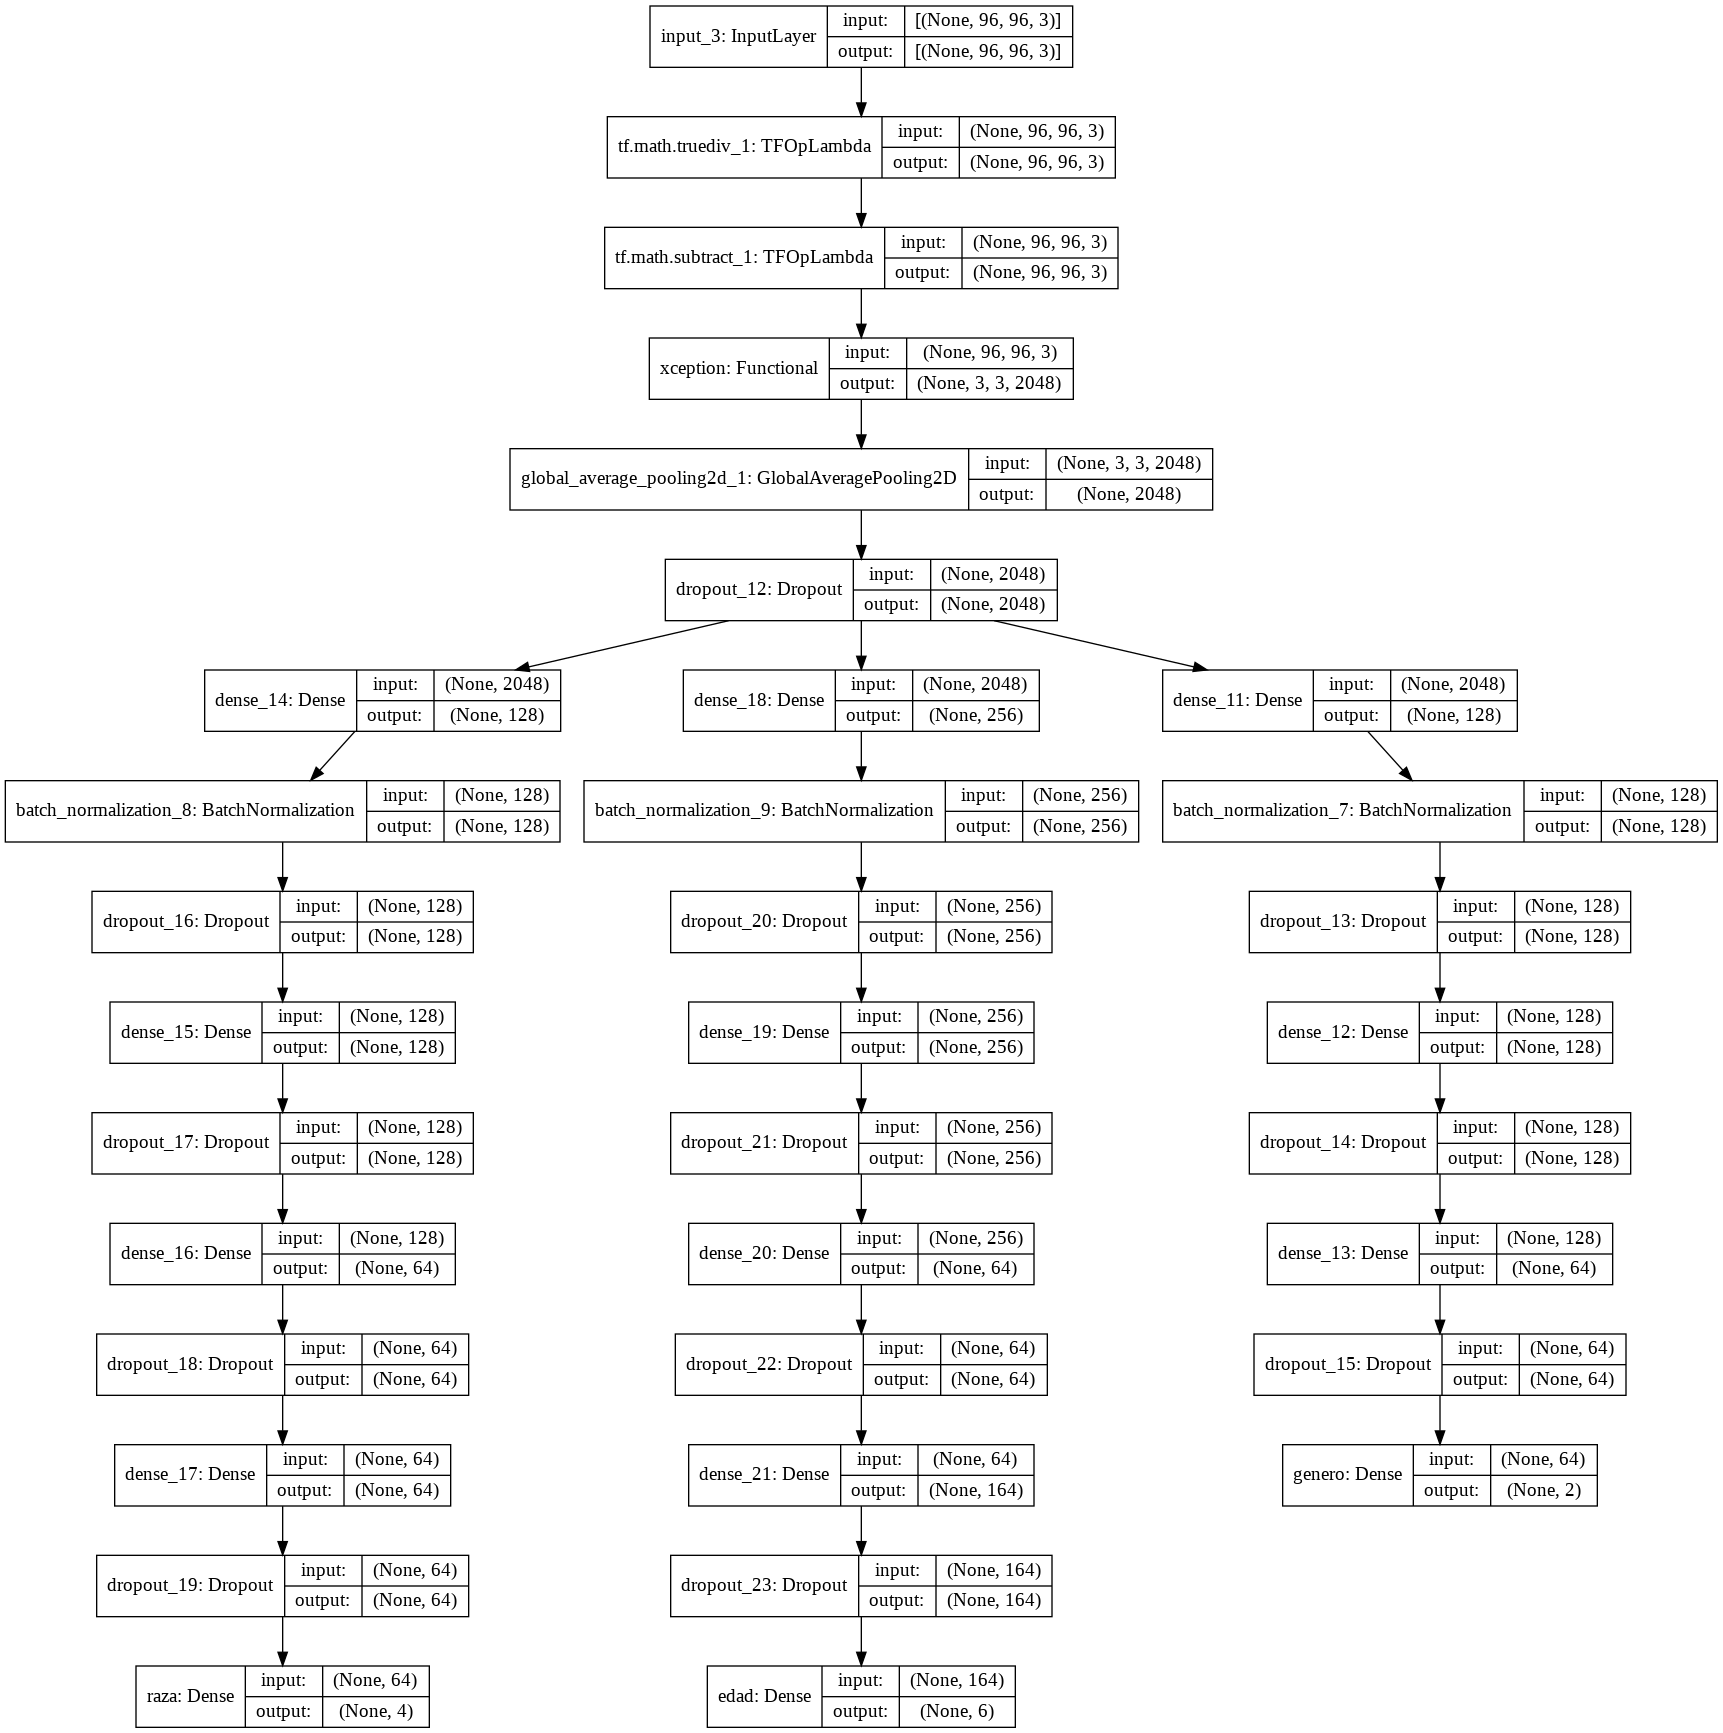

In [22]:
# Observar estructura de la CNN creada
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True,expand_nested=False)
#model.summary()
#len(model.trainable_variables)

In [ ]:
pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-ai92vuaw
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-ai92vuaw
     |████████████████████████████████| 798kB 12.3MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.1-cp37-none-any.whl size=12959 sha256=cc4658cdca737f98ef35f516237037b3a68068eecdb2edee73a9b7c962889038
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1skwrow/wheels/63/ee/ff/e163fd012b516d0922da126313ce2133e97f712726dc4dc722
Successfully built visualkeras


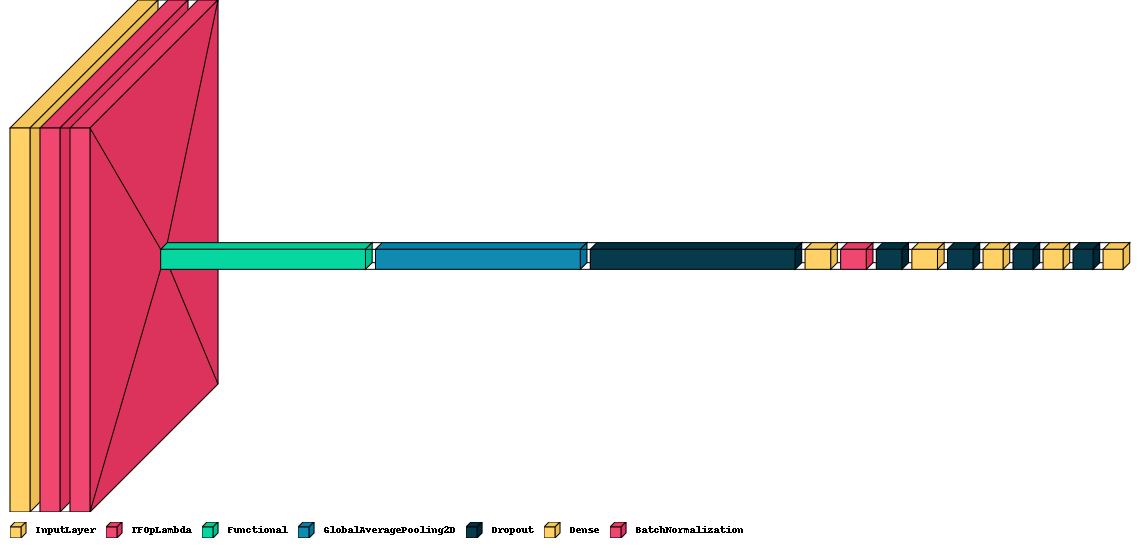

In [ ]:
import visualkeras

model1 = model

#visualkeras.graph_view(model1, legend=True)  # font is optional!


visualkeras.layered_view(model1,legend=True) # display using your system viewer
#visualkeras.layered_view(model1, to_file='output1.png') # write to disk


In [23]:

model.evaluate(X_test,[genero_test,raza_test,edad_test],batch_size=32)
# train the model on the new data for a few epochs



149/149 [==============================] - 40s 71ms/step - loss: 5.6173 - genero_loss: 0.7053 - raza_loss: 1.3767 - edad_loss: 1.9440 - genero_accuracy: 0.5299 - raza_accuracy: 0.2562 - edad_accuracy: 0.1218


[5.617278099060059,
 0.7052592635154724,
 1.3767127990722656,
 1.9439679384231567,
 0.5298586487770081,
 0.25617218017578125,
 0.12175564467906952]

In [24]:
# Entrenar sólo la capa superior  (de clasificación) del modelo

#criterio de parada de 3 epocas, si el peso no disminuye en 3 epocas, se detiene el entrenamiento
# y se restauran los mejores pesos
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)
initial_epochs = 15
history = model.fit(X_train,[genero_train,raza_train,edad_train],batch_size=32,
                    epochs=initial_epochs,
                    validation_split=0.2,
                    verbose=1,callbacks=[callback])


Epoch 1/15
474/474 [==============================] - 48s 92ms/step - loss: 4.7063 - genero_loss: 0.5991 - raza_loss: 1.4194 - edad_loss: 1.4937 - genero_accuracy: 0.7338 - raza_accuracy: 0.3757 - edad_accuracy: 0.4556 - val_loss: 3.7090 - val_genero_loss: 0.3961 - val_raza_loss: 1.2271 - val_edad_loss: 1.1419 - val_genero_accuracy: 0.8198 - val_raza_accuracy: 0.4482 - val_edad_accuracy: 0.5677
Epoch 2/15
474/474 [==============================] - 42s 90ms/step - loss: 4.0124 - genero_loss: 0.4550 - raza_loss: 1.2473 - edad_loss: 1.2688 - genero_accuracy: 0.7922 - raza_accuracy: 0.4376 - edad_accuracy: 0.5240 - val_loss: 3.4836 - val_genero_loss: 0.3899 - val_raza_loss: 1.1286 - val_edad_loss: 1.0800 - val_genero_accuracy: 0.8256 - val_raza_accuracy: 0.4851 - val_edad_accuracy: 0.5851
Epoch 3/15
474/474 [==============================] - 42s 90ms/step - loss: 3.8048 - genero_loss: 0.4302 - raza_loss: 1.1891 - edad_loss: 1.2003 - genero_accuracy: 0.8036 - raza_accuracy: 0.4750 - edad_ac

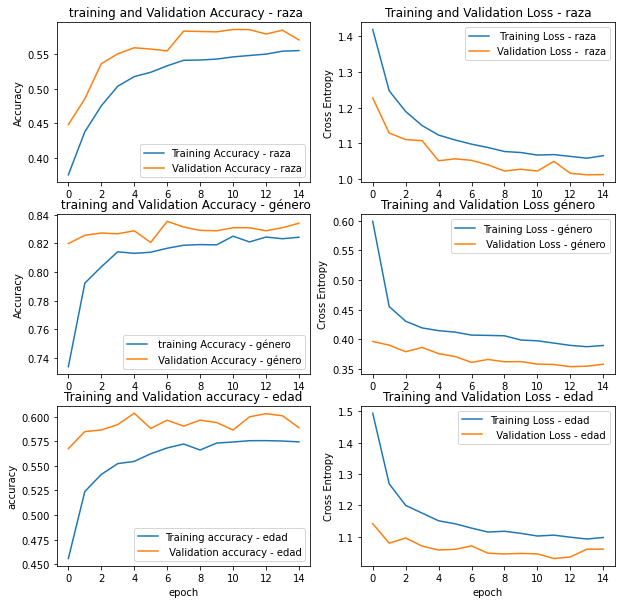

In [27]:
%matplotlib inline

etnia_acc = history.history['raza_accuracy']
etnia_loss = history.history['raza_loss']
val_etnia_acc = history.history['val_raza_accuracy']
val_etnia_loss = history.history['val_raza_loss']

gender_acc = history.history['genero_accuracy']
gender_loss = history.history['genero_loss']
val_gender_acc = history.history['val_genero_accuracy']
val_gender_loss = history.history['val_genero_loss']

edad_acc = history.history['edad_accuracy']
edad_loss = history.history['edad_loss']
val_edad_acc = history.history['val_edad_accuracy']
val_edad_loss = history.history['val_edad_loss']



plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(etnia_acc, label='Training Accuracy - raza')
plt.plot(val_etnia_acc, label='Validation Accuracy - raza')
plt.legend(loc='best')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim())-0.2,1])
plt.title(' training and Validation Accuracy - raza')

plt.subplot(3, 2, 2)
plt.plot(etnia_loss, label=' Training Loss - raza')
plt.plot(val_etnia_loss, label='Validation Loss -  raza')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
#plt.ylim([.5,0.5+max(plt.ylim())])
plt.title('Training and Validation Loss - raza')
#plt.xlabel('epoch')

plt.subplot(3, 2, 3)

plt.plot(gender_acc, label=' training Accuracy - género')
plt.plot(val_gender_acc, label=' Validation Accuracy - género')
plt.legend(loc='best')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim())-0.2,1])
plt.title(' training and Validation Accuracy - género')

plt.subplot(3, 2, 4)
plt.plot(gender_loss, label='Training Loss - género ')
plt.plot(val_gender_loss, label=' Validation Loss - género')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss género')
#plt.xlabel('epoch')


plt.subplot(3, 2, 5)
plt.plot(edad_acc, label='Training accuracy - edad')
plt.plot(val_edad_acc, label=' Validation accuracy - edad')
plt.legend(loc='best')
plt.ylabel('accuracy')
#plt.ylim([0,15.0])
plt.title('Training and Validation accuracy - edad')
plt.xlabel('epoch')

plt.subplot(3, 2, 6)
plt.plot(edad_loss, label='Training Loss - edad')
plt.plot(val_edad_loss, label='  Validation Loss - edad')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss - edad')
plt.xlabel('epoch')

plt.savefig('CNN_1.png', dpi=100)
plt.show()


In [ ]:
plt.savefig('foo.png')

<Figure size 432x288 with 0 Axes>

In [28]:
model.evaluate(X_test,[genero_test,raza_test,edad_test],verbose=1)

149/149 [==============================] - 10s 70ms/step - loss: 3.3661 - genero_loss: 0.3495 - raza_loss: 1.0067 - edad_loss: 1.0923 - genero_accuracy: 0.8411 - raza_accuracy: 0.5773 - edad_accuracy: 0.5662


[3.3660638332366943,
 0.3494630455970764,
 1.006652593612671,
 1.0923402309417725,
 0.8411056995391846,
 0.5773369669914246,
 0.5661531686782837]

In [30]:
# Numero de capaz del modelo 
print("Number of layers in the base model: ", len(base_model.layers))

# capa en la que comenzar el fine tuning
fine_tune_at = 0

# Congelar el resto de capas
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
tf.math.truediv_1 (TFOpLambda)  (None, 96, 96, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract_1 (TFOpLambda) (None, 96, 96, 3)    0           tf.math.truediv_1[0][0]          
__________________________________________________________________________________________________
xception (Functional)           (None, 3, 3, 2048)   20861480    tf.math.subtract_1[0][0]         
______________________________________________________________________________________________

In [ ]:


#initial_learning_rate = 0.0001
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  #  initial_learning_rate,
  #  decay_steps=100000,
  #  decay_rate=0.96,
  # staircase=True)

# Compilar modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "genero":  'sparse_categorical_crossentropy',
        "etnia": 'sparse_categorical_crossentropy',
       "edad": 'sparse_categorical_crossentropy',
    },
    metrics={
       # "genero": [keras.metrics.CategoricalAccuracy()], 
       "genero": 'accuracy',
       "etnia": 'accuracy', 
        "edad": 'accuracy',
      
    },
 #  loss_weights={"genero": 1, "etnia": 2,"edad": 0.05},

    #loss_weights={"genero": 6, "etnia": 8,"edad": 10},
    loss_weights={"genero": 0.5, "etnia": 1,"edad": 2},
)


In [32]:

fine_tune_epochs = 20 # sintonía fina 
#initial_epochs=1
history2 = model.fit(X_train,[genero_train,raza_train,edad_train],batch_size=32,
                    epochs=initial_epochs + fine_tune_epochs,
                     initial_epoch=history.epoch[-1],
                    validation_split=0.2,verbose=1,callbacks=[callback])

Epoch 15/35
474/474 [==============================] - 43s 90ms/step - loss: 3.4075 - genero_loss: 0.3872 - raza_loss: 1.0518 - edad_loss: 1.0811 - genero_accuracy: 0.8269 - raza_accuracy: 0.5546 - edad_accuracy: 0.5802 - val_loss: 3.2167 - val_genero_loss: 0.3524 - val_raza_loss: 0.9980 - val_edad_loss: 1.0213 - val_genero_accuracy: 0.8325 - val_raza_accuracy: 0.5914 - val_edad_accuracy: 0.5898
Epoch 16/35
474/474 [==============================] - 42s 89ms/step - loss: 3.4326 - genero_loss: 0.3909 - raza_loss: 1.0597 - edad_loss: 1.0887 - genero_accuracy: 0.8276 - raza_accuracy: 0.5494 - edad_accuracy: 0.5786 - val_loss: 3.2511 - val_genero_loss: 0.3557 - val_raza_loss: 1.0011 - val_edad_loss: 1.0361 - val_genero_accuracy: 0.8301 - val_raza_accuracy: 0.5901 - val_edad_accuracy: 0.5948
Epoch 17/35
474/474 [==============================] - 42s 89ms/step - loss: 3.4037 - genero_loss: 0.3866 - raza_loss: 1.0479 - edad_loss: 1.0813 - genero_accuracy: 0.8276 - raza_accuracy: 0.5560 - edad

In [ ]:
etnia_acc += history2.history['raza_accuracy']
etnia_loss += history2.history['raza_loss']
val_etnia_acc += history2.history['val_raza_accuracy']
val_etnia_loss += history2.history['val_raza_loss']

gender_acc += history2.history['genero_accuracy']
gender_loss += history2.history['genero_loss']
val_gender_acc += history2.history['val_genero_accuracy']
val_gender_loss += history2.history['val_genero_loss']

edad_acc += history2.history['edad_accuracy']
edad_loss += history2.history['edad_loss']
val_edad_acc += history2.history['val_edad_accuracy']
val_edad_loss += history2.history['val_edad_loss']

f_tunning=15

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(etnia_acc, label='training Accuracy - raza')
plt.plot(val_etnia_acc, label='Validation Accuracy - raza')
plt.legend(loc='best')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.plot([f_tunning,f_tunning],
          plt.ylim(), label='Comienzo fine tuning')
plt.legend(loc='lower right')
plt.title('training and Validation Accuracy - raza')

plt.subplot(3, 2, 2)
plt.plot(etnia_loss, label='Training Loss - raza')
plt.plot(val_etnia_loss, label=' Validation Loss - raza')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.plot([f_tunning,f_tunning],
          plt.ylim(), label='Comienzo fine tuning')
plt.title('race Training and Validation Loss')
#plt.xlabel('epoch')

plt.subplot(3, 2, 3)

plt.plot(gender_acc, label='training Accuracy - género')
plt.plot(val_gender_acc, label='Validation Accuracy - género')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Comienzo fine tuning')
plt.title('training and Validation Accuracy - género')

plt.subplot(3, 2, 4)
plt.plot(gender_loss, label='Training Loss - género')
plt.plot(val_gender_loss, label='Validation Loss - género')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.plot([f_tunning,f_tunning],
          plt.ylim(), label='Comienzo fine tuning')
plt.title('Training and Validation Loss - género')
#plt.xlabel('epoch')


plt.subplot(3, 2, 5)
plt.plot(edad_acc, label='Training accuracy - edad')
plt.plot(val_edad_acc, label='Validation accuracy - edad')
plt.legend(loc='best')
plt.ylabel('accuracy')
#plt.ylim([0,1.0])
plt.plot([f_tunning,f_tunning],
          plt.ylim(), label='Comienzo fine tuning')
plt.title('Training and Validation accuracy - edad')
plt.xlabel('epoch')

plt.subplot(3, 2, 6)
plt.plot(edad_loss, label='Training Loss - edad')
plt.plot(val_edad_loss, label=' Validation Loss - edad')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.plot([f_tunning,f_tunning],
          plt.ylim(), label='Comienzo fine tuning')
plt.title('Training and Validation Loss- edad' )
plt.xlabel('epoch')

plt.savefig('CNN_2.png', dpi=100)
plt.show()


In [ ]:
test_loss, test_acc, *results=model.evaluate(X_test,[genero_test,etnia_test,edad_test],batch_size=32,verbose=1)


149/149 [==============================] - 4s 28ms/step - loss: 2.1344 - genero_loss: 0.2037 - etnia_loss: 0.5049 - edad_loss: 0.7638 - genero_accuracy: 0.9120 - etnia_accuracy: 0.8299 - edad_accuracy: 0.6926


In [ ]:
model.save('CNN.h5')

In [ ]:
#predict
y_pred= model.predict(X_test)


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#------ Genero------------#
y_pred1 = np.argmax(y_pred[0], axis = 1) # genero

summary= classification_report(y_test['genero'], y_pred1, 
                               target_names=['Masculino',
                                             'Femenino'],
                               output_dict=False,digits=4)
print(summary)
print("Matriz de confusión:")
print (confusion_matrix(y_test['genero'], y_pred1))

              precision    recall  f1-score   support

   Masculino     0.8835    0.9443    0.9129      2442
    Femenino     0.9361    0.8677    0.9006      2297

    accuracy                         0.9072      4739
   macro avg     0.9098    0.9060    0.9067      4739
weighted avg     0.9090    0.9072    0.9069      4739

Matriz de confusión:
[[2306  136]
 [ 304 1993]]


In [ ]:
#------ Raza------------#
y_pred2 = np.argmax(y_pred[1], axis = 1) # genero

summary= classification_report(y_test['raza'], y_pred2, 
                               target_names=['caucasico','africano/af.americano',
                                                  'asiático','latino/M.Oriente/indio.'],
                               output_dict=False,digits=4)
print(summary)
print("Matriz de confusión:")
print (confusion_matrix(y_test['raza'], y_pred2))

                         precision    recall  f1-score   support

              caucasico     0.8749    0.8584    0.8666      2020
  africano/af.americano     0.8989    0.7260    0.8032       894
               asiático     0.8201    0.8361    0.8280       714
latino/M.Oriente/indio.     0.6343    0.7462    0.6857      1111

               accuracy                         0.8038      4739
              macro avg     0.8070    0.7917    0.7959      4739
           weighted avg     0.8147    0.8038    0.8064      4739

Matriz de confusión:
[[1734   16   70  200]
 [  32  649    8  205]
 [  38    6  597   73]
 [ 178   51   53  829]]


In [ ]:
#------ Edad------------#
y_pred3 = np.argmax(y_pred[2], axis = 1) # genero

summary= classification_report(y_test['edad'], y_pred3, 
                               target_names=['0-10','11-20',
                                                  '21-35','36-50','51-65','65+'],digits=4,
                               output_dict=False)
print(summary)
print("Matriz de confusión:")
print (confusion_matrix(y_test['edad'], y_pred3))


              precision    recall  f1-score   support

        0-10     0.8571    0.9423    0.8977       624
       11-20     0.6071    0.0514    0.0947       331
       21-35     0.7449    0.8736    0.8041      2049
       36-50     0.4611    0.4569    0.4590       766
       51-65     0.5250    0.5872    0.5543       608
         65+     0.8634    0.4377    0.5809       361

    accuracy                         0.6879      4739
   macro avg     0.6765    0.5582    0.5651      4739
weighted avg     0.6850    0.6879    0.6621      4739

Matriz de confusión:
[[ 588    7   28    0    1    0]
 [  80   17  229    5    0    0]
 [  17    4 1790  216   22    0]
 [   1    0  303  350  112    0]
 [   0    0   49  177  357   25]
 [   0    0    4   11  188  158]]


In [ ]:
model.evaluate(X_test,[edad_test,genero_test],batch_size=32)
# train the model on the new data for a few epochs